# ATIPICAL MultiView and NoveltyDetection

In [83]:
from dotenv import load_dotenv, find_dotenv
import numpy as np
import datetime, os
import tarfile
import os
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical, array_to_img, img_to_array, load_img, image_dataset_from_directory
from keras import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import datetime

In [84]:
PATH_TO_SMALL_ROI_TYP_FOR_KERAS = "/home/onyxia/work/data/Images_ROI/Images_ROI_Typ_for_multiview_echant"
RECTO_PATH = os.path.join(PATH_TO_SMALL_ROI_TYP_FOR_KERAS,'RECTO')
VERSO_PATH = os.path.join(PATH_TO_SMALL_ROI_TYP_FOR_KERAS,'VERSO')

In [85]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNELS = 3
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)
BATCH_SIZE = 32
CLASSES = 8

In [86]:
tf.random.set_seed(1234)

In [87]:
trainR  = image_dataset_from_directory(RECTO_PATH,
image_size=(IMG_WIDTH,IMG_HEIGHT),
batch_size=BATCH_SIZE,
validation_split=0.2,
subset='training',
seed=12345,
crop_to_aspect_ratio=True,
shuffle=True)

valR = image_dataset_from_directory(RECTO_PATH,
image_size=(IMG_WIDTH,IMG_HEIGHT),
batch_size=BATCH_SIZE,
validation_split=0.2,
subset='validation',
seed=12345,
crop_to_aspect_ratio=True,
shuffle=True)

trainV  = image_dataset_from_directory(VERSO_PATH,
image_size=(IMG_WIDTH,IMG_HEIGHT),
batch_size=BATCH_SIZE,
validation_split=0.2,
subset='training',
seed=12345,
crop_to_aspect_ratio=True,
shuffle=True)

valV = image_dataset_from_directory(VERSO_PATH,
image_size=(IMG_WIDTH,IMG_HEIGHT),
batch_size=BATCH_SIZE,
validation_split=0.2,
subset='validation',
seed=12345,
crop_to_aspect_ratio=True,
shuffle=True)

Found 2301 files belonging to 7 classes.
Using 1841 files for training.
Found 2301 files belonging to 7 classes.
Using 460 files for validation.
Found 2301 files belonging to 7 classes.
Using 1841 files for training.
Found 2301 files belonging to 7 classes.
Using 460 files for validation.


In [88]:
X_train_R = tf.zeros(shape=(32, 224, 224, 3),dtype=tf.float32)
y_train_tensor = tf.zeros(shape=(32,),dtype=tf.int32)
for recto in trainR:
    X_train_R = tf.concat([X_train_R,recto[0]],0)
    y_train_tensor = tf.concat([y_train_tensor,recto[1]],0)

X_train_V = tf.zeros(shape=(32, 224, 224, 3),dtype=tf.float32)
for verso in trainV:
    X_train_V = tf.concat([X_train_V,verso[0]],0)

X_test_V = tf.zeros(shape=(32, 224, 224, 3),dtype=tf.float32)
for verso in valV:
    X_test_V = tf.concat([X_test_V,verso[0]],0)

X_test_R = tf.zeros(shape=(32, 224, 224, 3),dtype=tf.float32)
y_test_tensor = tf.zeros(shape=(32,),dtype=tf.int32)
for recto in valR:
    X_test_R = tf.concat([X_test_R,recto[0]],0)
    y_test_tensor = tf.concat([y_test_tensor,recto[1]],0)

## Le modèle multi-vue

In [89]:
base_model = tf.keras.applications.EfficientNetB5(input_shape=INPUT_SHAPE,
include_top=False,
weights='imagenet')
model=base_model
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

base_model2 = tf.keras.applications.VGG16(input_shape=INPUT_SHAPE,
include_top=False,
weights='imagenet')
model2=base_model2
preprocess_input2 = tf.keras.applications.vgg16.preprocess_input

base_model.trainable = False
base_model2.trainable = False

inputs1 = tf.keras.Input(shape=(224, 224, 3))
x1 = preprocess_input(inputs1)
x1 = base_model(x1, training=False)
x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
x1 = tf.keras.layers.Dropout(0.2)(x1)
inputs2 = tf.keras.Input(shape=(224, 224, 3))
x2 = preprocess_input2(inputs2) # x2 = preprocess_input(inputs2)
x2 = base_model2(x2, training=False) # x2 = base_model(x2, training=False)
x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)
x2 = tf.keras.layers.Dropout(0.2)(x2)
fuz = tf.keras.layers.Concatenate()([x1, x2])
x = tf.keras.layers.Dense(1024,activation='relu')
x = tf.keras.layers.Dense(CLASSES, activation = 'softmax')(fuz)
outputs = x
model = tf.keras.Model(inputs=[inputs1,inputs2], outputs=outputs)

base_learning_rate = 10**(-3)
model.compile(optimizer=tf.keras.optimizers.
Adam(learning_rate=base_learning_rate),
loss="sparse_categorical_crossentropy",
metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem_2 (Sl  (None, 224, 224, 3)  0          ['input_16[0][0]']               
 icingOpLambda)                                                                                   
                                                                                                  
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                          

In [96]:
base_path = "/home/onyxia/work/pfe-deep-learning-maladies-plantes"
path_to_save = os.path.join(base_path,"save_models","multi_view",f'ECHANT_recto_EfficientNetB5_verso_VGG16_weight_imagenet_one_fc_layer_batch_size_{BATCH_SIZE}.h5')

In [97]:
model.load_weights(path_to_save)

## Atypiques & Exterieurs

In [98]:
PATH_TO_SMALL_ROI_ATY_FOR_KERAS = "/home/onyxia/work/data/Images_ROI/Images_ROI_Aty_for_multiview"
RECTO_PATH_ATY = os.path.join(PATH_TO_SMALL_ROI_ATY_FOR_KERAS,'RECTO')
VERSO_PATH_ATY = os.path.join(PATH_TO_SMALL_ROI_ATY_FOR_KERAS,'VERSO')

PATH_TO_SMALL_ROI_EXT_FOR_KERAS = "/home/onyxia/work/data/Images_ROI/Images_ROI_Ext_for_multiview"
RECTO_PATH_EXT = os.path.join(PATH_TO_SMALL_ROI_EXT_FOR_KERAS,'RECTO')
VERSO_PATH_EXT = os.path.join(PATH_TO_SMALL_ROI_EXT_FOR_KERAS,'VERSO')

In [99]:
AtyR = image_dataset_from_directory(RECTO_PATH_ATY,
                                                    image_size=(IMG_WIDTH,IMG_HEIGHT),
                                                    batch_size = 32,
                                                    labels = None,
                                                    label_mode = None,
                                                    seed=1234,
                                                    crop_to_aspect_ratio=True,
                                                    shuffle = True)
AtyV = image_dataset_from_directory(VERSO_PATH_ATY,
                                                    image_size=(IMG_WIDTH,IMG_HEIGHT),
                                                    batch_size = BATCH_SIZE,
                                                    labels = None,
                                                    seed=1234,
                                                    crop_to_aspect_ratio=True,
                                                    shuffle = True)
ExtR = image_dataset_from_directory(RECTO_PATH_EXT,
                                                    image_size=(IMG_WIDTH,IMG_HEIGHT),
                                                    batch_size = BATCH_SIZE,
                                                    labels = None,
                                                    seed=1234,
                                                    crop_to_aspect_ratio=True,
                                                    shuffle = True)
ExtV = image_dataset_from_directory(VERSO_PATH_EXT,
                                                    image_size=(IMG_WIDTH,IMG_HEIGHT),
                                                    batch_size = BATCH_SIZE,
                                                    labels = None,
                                                    seed=1234,
                                                    crop_to_aspect_ratio=True,
                                                    shuffle = True)

Found 649 files belonging to 1 classes.
Found 649 files belonging to 1 classes.
Found 394 files belonging to 1 classes.
Found 394 files belonging to 1 classes.


In [100]:
ExtR

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [101]:
Aty_R = tf.zeros(shape=(32,224, 224, 3),dtype=tf.float32)
for recto in AtyR:
    Aty_R = tf.concat([Aty_R,recto],0)

Aty_V = tf.zeros(shape=(32,224, 224, 3),dtype=tf.float32)
for verso in AtyV:
    Aty_V = tf.concat([Aty_V,verso],0)
    
Ext_R = tf.zeros(shape=(32,224, 224, 3),dtype=tf.float32)
for recto in ExtR:
    Ext_R = tf.concat([Ext_R,recto],0)

Ext_V = tf.zeros(shape=(32,224, 224, 3),dtype=tf.float32)
for verso in ExtV:
    Ext_V = tf.concat([Ext_V,verso],0)

14/14 [==============================] - 29s 2s/step


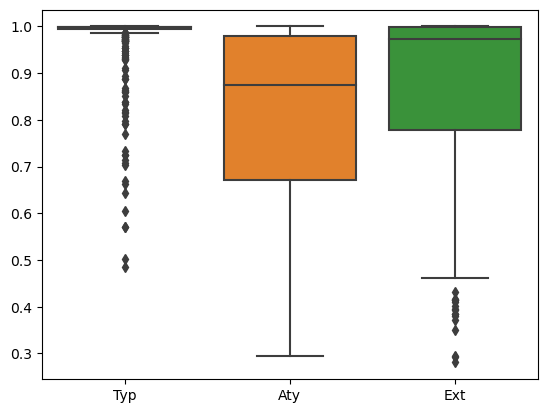

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
scoreTyp=np.max(model.predict(x=[X_test_R,X_test_V]),axis=-1)
scoreAty=np.max(model.predict(x=[Aty_R,Aty_V]),axis=-1)
scoreExt=np.max(model.predict(x=[Ext_R,Ext_V]),axis=-1)
score=np.concatenate((scoreTyp,scoreAty,scoreExt))
qui=np.concatenate((np.repeat("Typ",scoreTyp.shape[0]),
np.repeat("Aty",scoreAty.shape[0]),
np.repeat("Ext",scoreExt.shape[0])))
import pandas as pd
d = {'qui': qui, 'score': score}
df = pd.DataFrame(data=d)
ax = sns.boxplot(data=df,x=qui,y=score)
# plt.legend(labels=['Typ', 'Aty','Ext'])
plt.show()